###### Inicialização

In [ ]:
!pip install yfinance arch

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, date
from IPython.display import Markdown
from itertools import product

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots as tsa

from sklearn import metrics
from arch import arch_model

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (22,6)

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

import seaborn as sns
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

In [ ]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["figure.figsize"] = (22,6)

In [ ]:
def resultado_adf(resultado, alpha = .05):
  adf, pvalue, usedlag, nobs, critical = resultado[0:5]
  
  display(Markdown('Statistics=%.3f, p-valor=%.8f' % (adf, pvalue)))
  # interpretando resultados
  if pvalue > alpha:
      display(Markdown("**A série não é estacionária (falhamos em rejeitar H0)**"))
  else:
      display(Markdown('**A série é estacionária (rejeitamos H0)**'))

In [ ]:
def resultado_white(resultado, alpha = .05):
  lm, p_value, fvalue, fp_value = resultado[0:5]
  
  display(Markdown('Statistics=%.3f, p-valor=%.8f' % (lm, p_value)))
  # interpretando resultados
  if p_value > alpha:
      display(Markdown("**A série não é heterocedástica (falhamos em rejeitar H0)**"))
  else:
      display(Markdown('**A série é heterocedástica (rejeitamos H0)**'))

In [ ]:
mape = lambda y_true, y_pred: np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def auto_ARIMA(experimentos, dados):
  resultados = []
  
  for experimento in tqdm(experimentos):
    try: 
      modelo = sm.tsa.arima.ARIMA(dados, order=experimento).fit()
    except:
      continue
    mae = metrics.mean_absolute_error(dados, modelo.fittedvalues)
    mape_erro = mape(dados, modelo.fittedvalues)
    resultados.append([experimento, modelo.aic, mae, mape_erro, modelo])

  resultados_df = pd.DataFrame(resultados)
  resultados_df.columns = ['(p, d, q)', 'AIC', 'MAE', 'MAPE', 'modelo']
  
  resultados = resultados_df.sort_values(by='MAPE', ascending=True).reset_index(drop=True) #ordena pelo AIC
  
  return resultados

In [ ]:
def auto_GARCH(experimentos, dados):
  resultados = []
  
  for experimento in tqdm(experimentos):
    try: 
      modelo = arch_model(dados, vol="GARCH", p=experimento[0], q=experimento[1]).fit()
    except:
      continue
    aic = modelo.aic
    resultados.append([experimento, aic])
    del modelo

  resultados_df = pd.DataFrame(resultados)
  resultados_df.columns = ['(p, q)', 'AIC']
  
  resultados = resultados_df.sort_values(by='AIC', ascending=True).reset_index(drop=True) #ordena pelo AIC
  
  return resultados

Captura dos dados de câmbio do dolar/real

In [ ]:
serie_dolar = pdr.get_data_yahoo("USDBRL=X", start="2007-01-01", end="2022-12-31")['Adj Close'].dropna()
serie_dolar.name = "dolar"

# Análise de Séries temporais (Sessão 15)
---
Modelando Séries (parte 6)

## Heterocedasticidade

Uma suposição importante da regressão é que a variância do termo de erro é constante entre as observações. Se o erro tiver uma variância constante, então os erros são chamados de homocedásticos, caso contrário, heterocedásticos. No caso de erros heterocedásticos (variância não constante), os métodos de estimação padrão tornam-se ineficientes. Normalmente, para avaliar a suposição de homocedasticidade, os resíduos são plotados.

Ou seja, uma série temporal é heterocedástica se sua variância muda ao longo do tempo. Caso contrário, o conjunto de dados é homocedástico.

O teste de White (Halbert White, 1980) propôs um teste muito semelhante ao de Breusch-Pagen. O teste de White para Heterocedasticidade é geral porque não depende das suposições de normalidade e também é fácil de implementar. Devido à generalidade do teste de White, ele também pode identificar o viés de especificação. Tanto o teste de White quanto o teste de Breusch-Pagan são baseados nos resíduos do modelo ajustado.

- $H_0$ - A hipótese nula é que as variâncias dos erros são iguais, ou seja: $σ^2_i = σ^2$.
- $H_1$ - A hipótese alternativa (aquela que você está testando) é que as variâncias não são iguais: $σ^2_i ≠ σ^2$.

In [ ]:
serie_dolar_df = serie_dolar.to_frame().asfreq('B').dropna()
serie_dolar_df["indice"] = serie_dolar_df.reset_index(drop=True).reset_index().index + 1
serie_dolar_df["diff_1"] = serie_dolar.diff(1)
serie_dolar_df["retornos"] = serie_dolar.pct_change() * 100
serie_dolar_df = serie_dolar_df[1:]

serie_dolar_df.head()

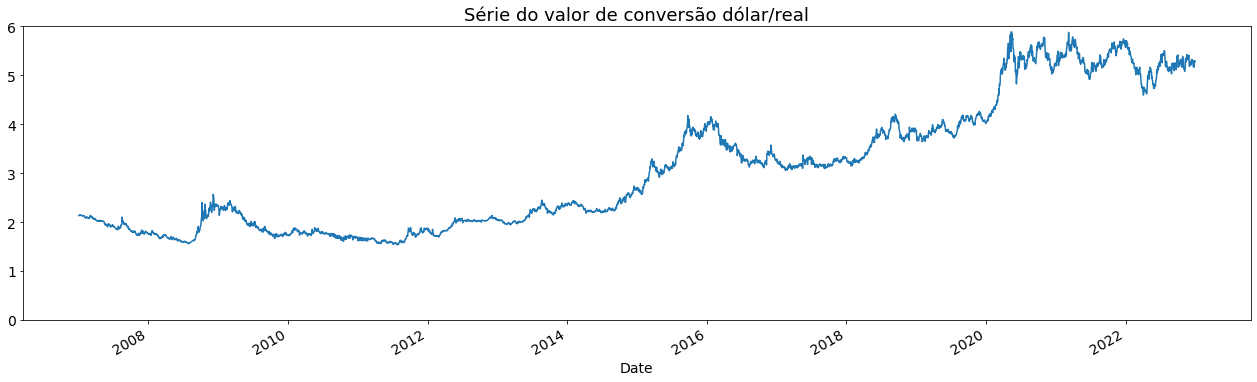

In [13]:
_ = serie_dolar_df.dolar.plot(title="Série do valor de conversão dólar/real", ylim=(0,6))

In [14]:
serie_dolar_df["dolar_log_diff"] = serie_dolar_df.dolar.apply(np.log).diff()
serie_dolar_df = serie_dolar_df.dropna()

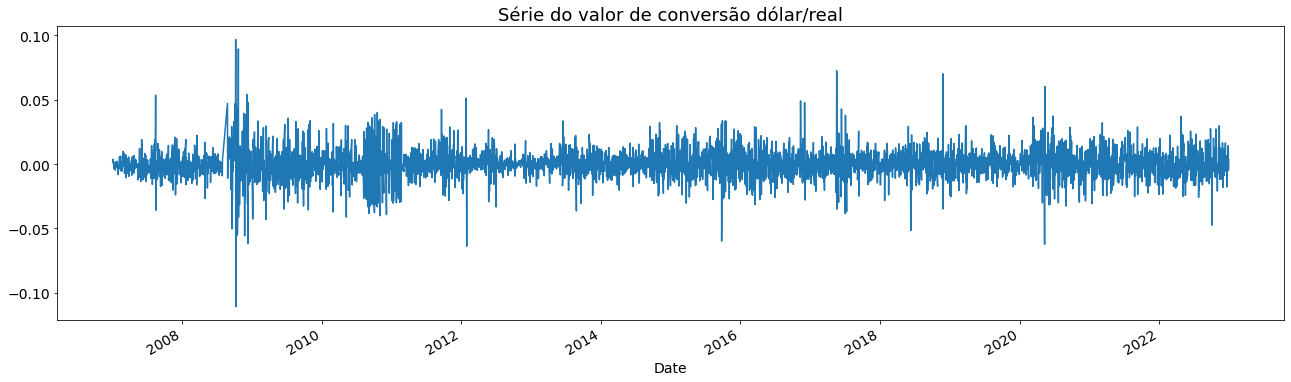

In [15]:
_ = serie_dolar_df.dolar_log_diff.plot(title="Série do valor de conversão dólar/real")

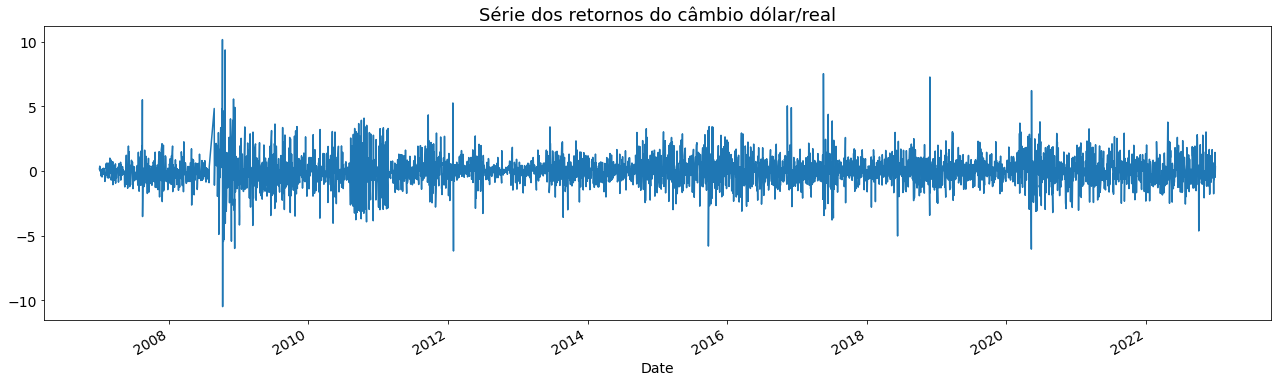

In [16]:
_ = serie_dolar_df.retornos.plot(title="Série dos retornos do câmbio dólar/real")

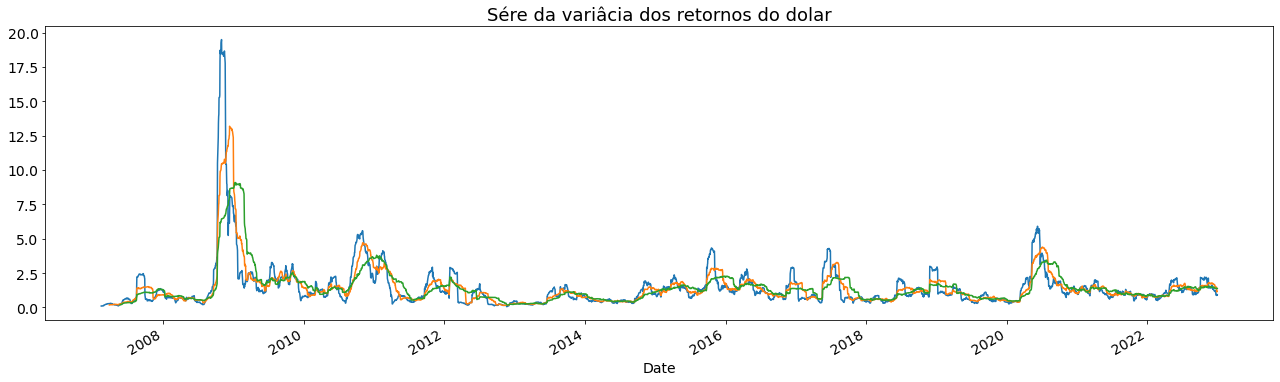

In [17]:
ax = serie_dolar_df.retornos.rolling(30).var().plot(title = "Sére da variâcia dos retornos do dolar")
serie_dolar_df.retornos.rolling(60).var().plot(ax = ax)
_ =serie_dolar_df.retornos.rolling(100).var().plot(ax = ax)

In [18]:
olsr = sm.formula.ols("retornos ~ indice", serie_dolar_df).fit()
resultado_white(sm.stats.diagnostic.het_white(olsr.resid, olsr.model.exog))

Statistics=18.822, p-valor=0.00008183

**A série é heterocedástica (rejeitamos H0)**

In [19]:
olsr = sm.formula.ols("dolar_log_diff ~ indice", serie_dolar_df).fit()
resultado_white(sm.stats.diagnostic.het_white(olsr.resid, olsr.model.exog))

Statistics=18.955, p-valor=0.00007657

**A série é heterocedástica (rejeitamos H0)**

## ARCH — Autoregressive Conditional Heteroskedasticity

Modelos ARCH são necessários quando precisamos modelar a mudança da variância da série. Seu nome representa:
- Autoregressivo: O valor atual pode ser expresso em função dos antetoriores
- Condicional: A variância é basiada nos erros passados
- Heteroscedasticidade: A série possui uma variância inconstante

Na prática, pode ser usado para modelar a variância esperada nos resíduos após outro modelo autorregressivo ter sido usado, como um ARMA ou similar. 

Como só podemos dizer se o modelo ARCH é apropriado ou não elevando os resíduos ao quadrado e examinando o correlograma, também precisamos garantir que a média dos resíduos seja zero.

Fundamentalmente, o ARCH só deve ser aplicado a séries que não tenham tendências ou efeitos sazonais, ou seja, que não tenham correlação serial (evidente). O ARIMA é frequentemente aplicado a tais séries (ou mesmo ao SARIMA), ponto em que o ARCH pode ser uma boa opção.

O modelo ARCH(p) é simplesmente um modelo AR(p) aplicado à variância de uma série temporal.

ARCH(1):

Uma série temporal $𝜖(t)$ é dada para cada instância por $𝜖(t) = w(t) * σ(t)$, onde $w(t)$ é um ruído branco de média zero e variância unitária.

\begin{align}
Var(X_t|X_{t-1}) = \sigma^2_t = \alpha_0 + \alpha_1 * X^2_{t-1}
\end{align}

onde $\alpha_0$ e $\alpha_1$ são parâmetros do modelo e $\alpha_0 > 0, \alpha_1 \le 0$ para garantir que  a variância condicional é positiva. $X^2_{t-1}$ é o erro quadrático atrasado.

Dizemos que $𝜖(t)$ é um modelo heteroscedistico condicionalmente autoregressivo de ordem unitária, denotado por ARCH(1).

\begin{align}
𝜖_t = w_t * σ_t = w_t * \sqrt{(⍺_0 + ⍺_1 * 𝜖^2_{t-1})}
\end{align}

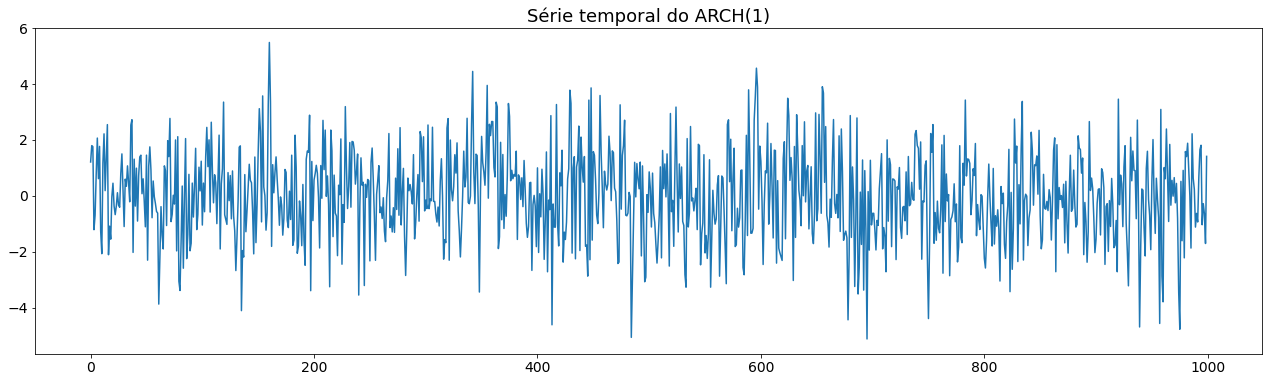

In [20]:
a = [2, .5]

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

arch1 = lambda t: w[t] * np.sqrt((a[0] + a[1] * y[t-1]**2)) #Equação do ARCH(1)

serie_arch_1 = pd.Series([arch1(t) for t in range(len(y))], name="arch1")

_ = serie_arch_1.plot(title="Série temporal do ARCH(1)")

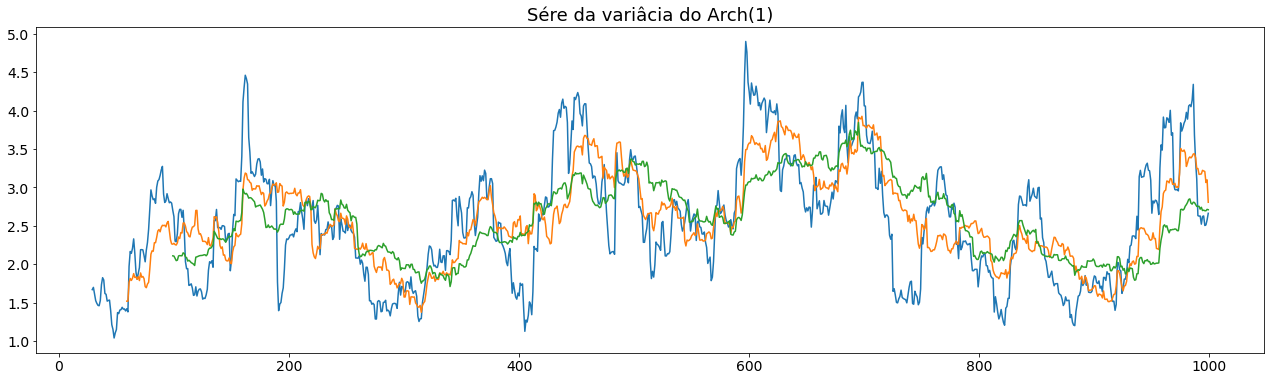

In [21]:
ax = serie_arch_1.rolling(30).var().plot(title = "Sére da variâcia do Arch(1)")
serie_arch_1.rolling(60).var().plot(ax = ax, title = "Sére da variâcia do Arch(1)")
_ = serie_arch_1.rolling(100).var().plot(ax = ax, title = "Sére da variâcia do Arch(1)")

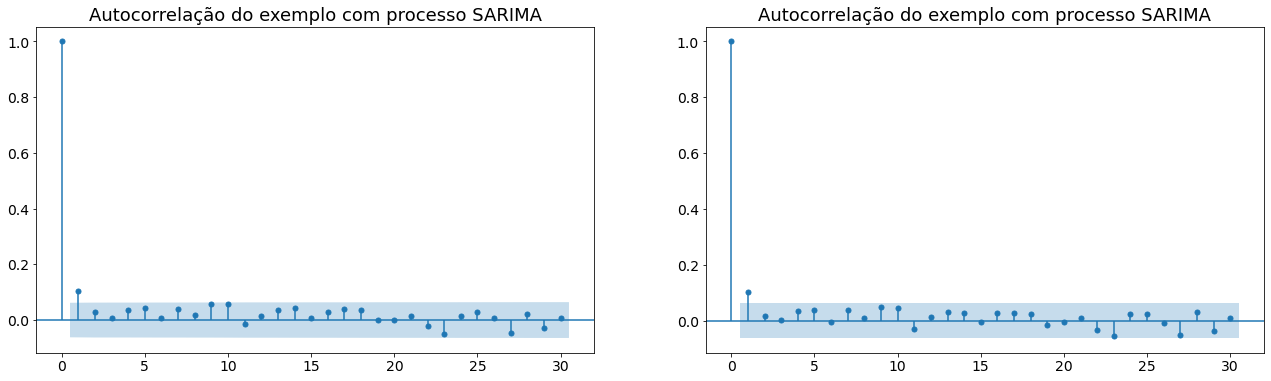

In [22]:
fig, axs = plt.subplots(1,2)
tsa.plot_acf(serie_arch_1, ax = axs[0], title="Autocorrelação do exemplo com processo SARIMA")
_ = tsa.plot_pacf(serie_arch_1, ax = axs[1], title="Autocorrelação do exemplo com processo SARIMA")

Observe que, em geral, esse processo se parece muito com o ruído branco; no entanto, dê uma olhada quando visualizarmos a série de quadrados.

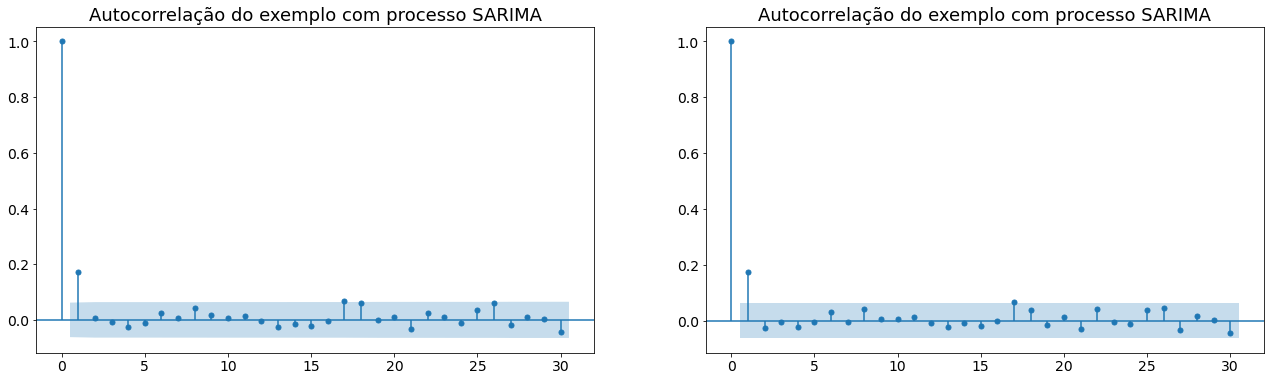

In [23]:
fig, axs = plt.subplots(1,2)
tsa.plot_acf(serie_arch_1**2, ax = axs[0], title="Autocorrelação do exemplo com processo SARIMA")
_ = tsa.plot_pacf(serie_arch_1**2, ax = axs[1], title="Autocorrelação do exemplo com processo SARIMA")


assim como, ARCH(2):

\begin{align}
𝜖_t = w_t * σ_t = w_t * \sqrt{(⍺_0 + ⍺_1 * 𝜖^2_{t-1} + ⍺_2 * 𝜖^2_{t-2})}
\end{align}


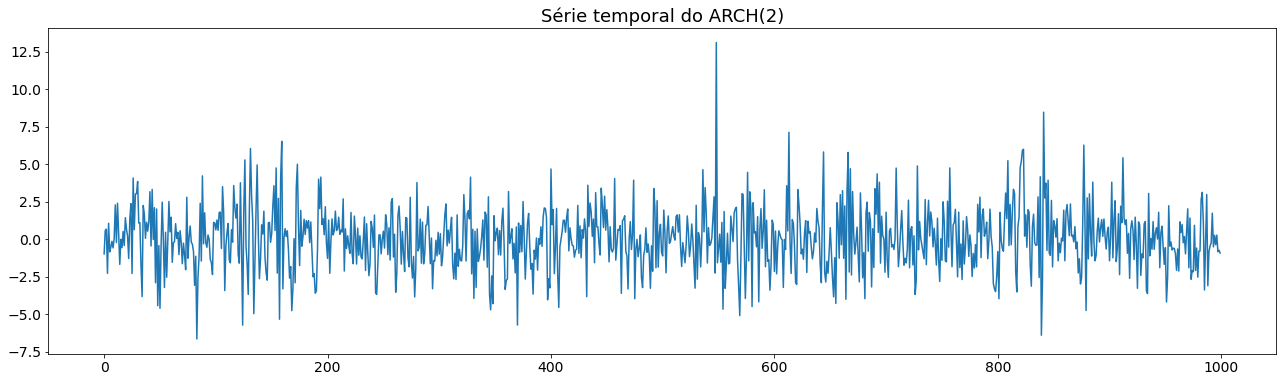

In [24]:
a = [2, .5, 1.8]

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

arch2 = lambda t: w[t] * np.sqrt((a[0] + a[1] * y[t-1]**2 + a[2] * y[t-2]**2)) #Equação do ARCH(2)

serie_arch_2 = pd.Series([arch2(t) for t in range(len(y))])

_ = serie_arch_2.plot(title="Série temporal do ARCH(2)")

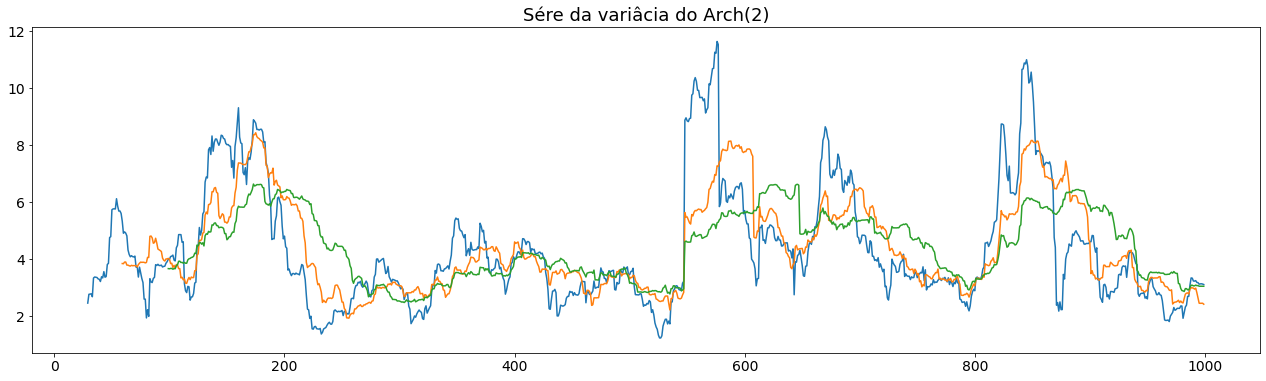

In [25]:
ax = serie_arch_2.rolling(30).var().plot(title = "Sére da variâcia do Arch(2)")
serie_arch_2.rolling(60).var().plot(ax = ax, title = "Sére da variâcia do Arch(2)")
_ = serie_arch_2.rolling(100).var().plot(ax = ax, title = "Sére da variâcia do Arch(2)")

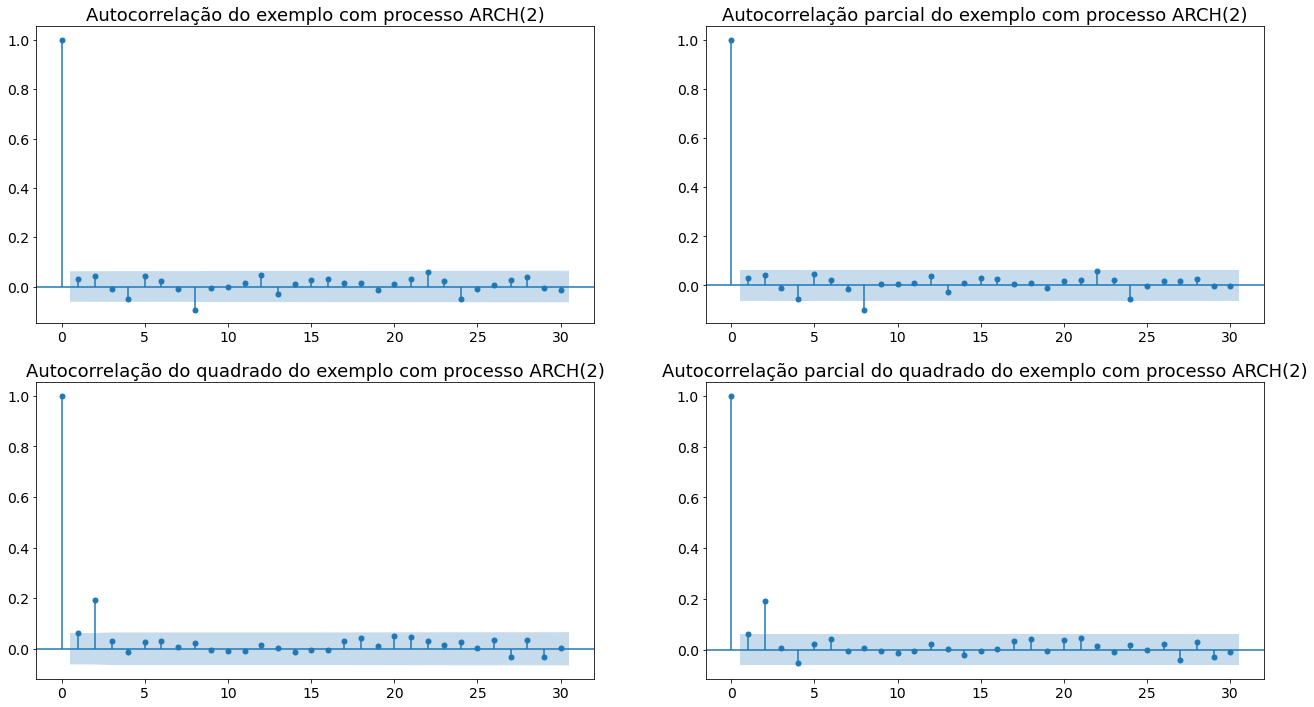

In [26]:
fig, axs = plt.subplots(2,2, figsize=(22,12))
tsa.plot_acf(serie_arch_2, ax = axs[0,0], title="Autocorrelação do exemplo com processo ARCH(2)")
tsa.plot_pacf(serie_arch_2, ax = axs[0,1], title="Autocorrelação parcial do exemplo com processo ARCH(2)")
tsa.plot_acf(serie_arch_2**2, ax = axs[1,0], title="Autocorrelação do quadrado do exemplo com processo ARCH(2)")
_ = tsa.plot_pacf(serie_arch_2**2, ax = axs[1,1], title="Autocorrelação parcial do quadrado do exemplo com processo ARCH(2)")

sendo assim, ARCH(p):

\begin{align}
𝜖_t = w_t * σ_t = w_t * \sqrt{(⍺_0 + \sum_{i=0}^p{⍺_i * 𝜖^2_{t-i}})}
\end{align}

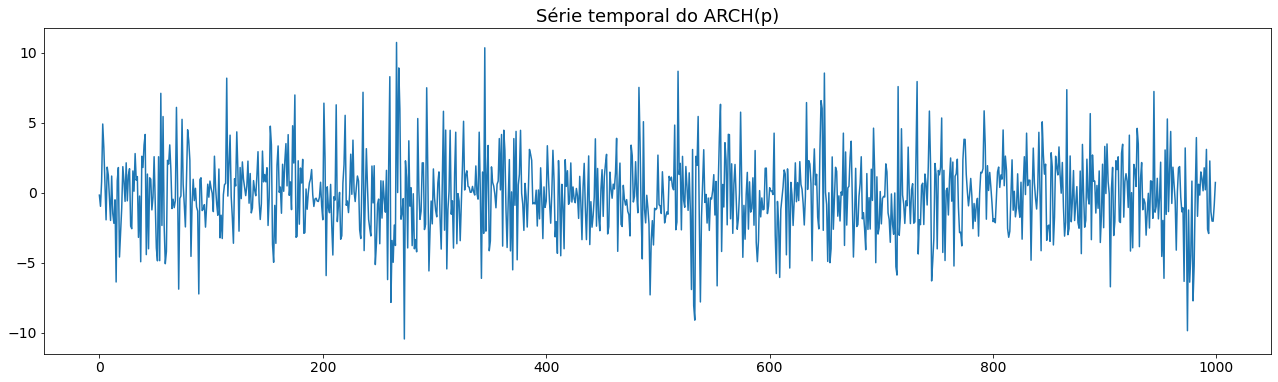

In [27]:
a = [2, .5, .2, 1.8, 2.1]

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

arch_p = lambda t: w[t] * np.sqrt((a[0] + np.sum([a * y[t-i]**2 for i,a in enumerate(a[1:])]) )) #Equação do ARCH(p)

serie_arch_p = pd.Series([arch_p(t) for t in range(len(y))])

# simulated ARCH(1) series, looks like white noise
_ = serie_arch_p.plot(title="Série temporal do ARCH(p)")

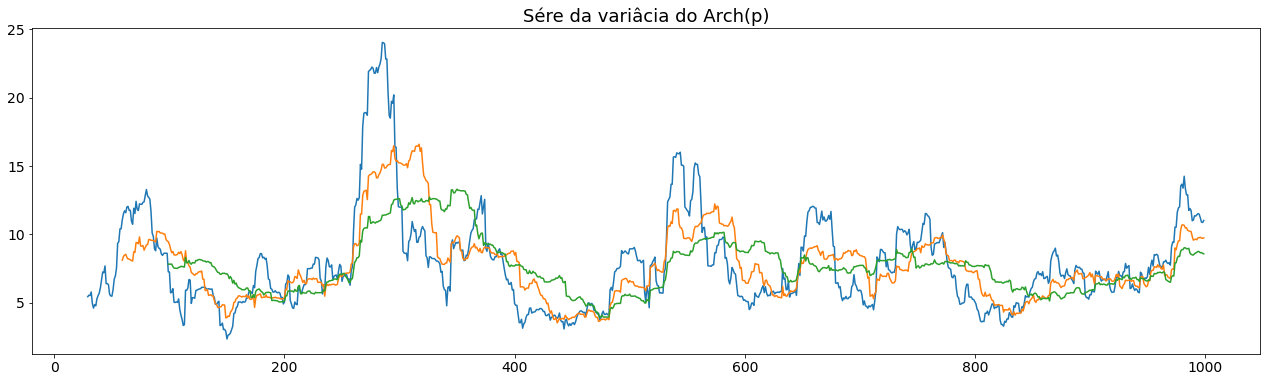

In [28]:
ax = serie_arch_p.rolling(30).var().plot(title = "Sére da variâcia do Arch(p)")
serie_arch_p.rolling(60).var().plot(ax = ax, title = "Sére da variâcia do Arch(p)")
_ = serie_arch_p.rolling(100).var().plot(ax = ax, title = "Sére da variâcia do Arch(p)")

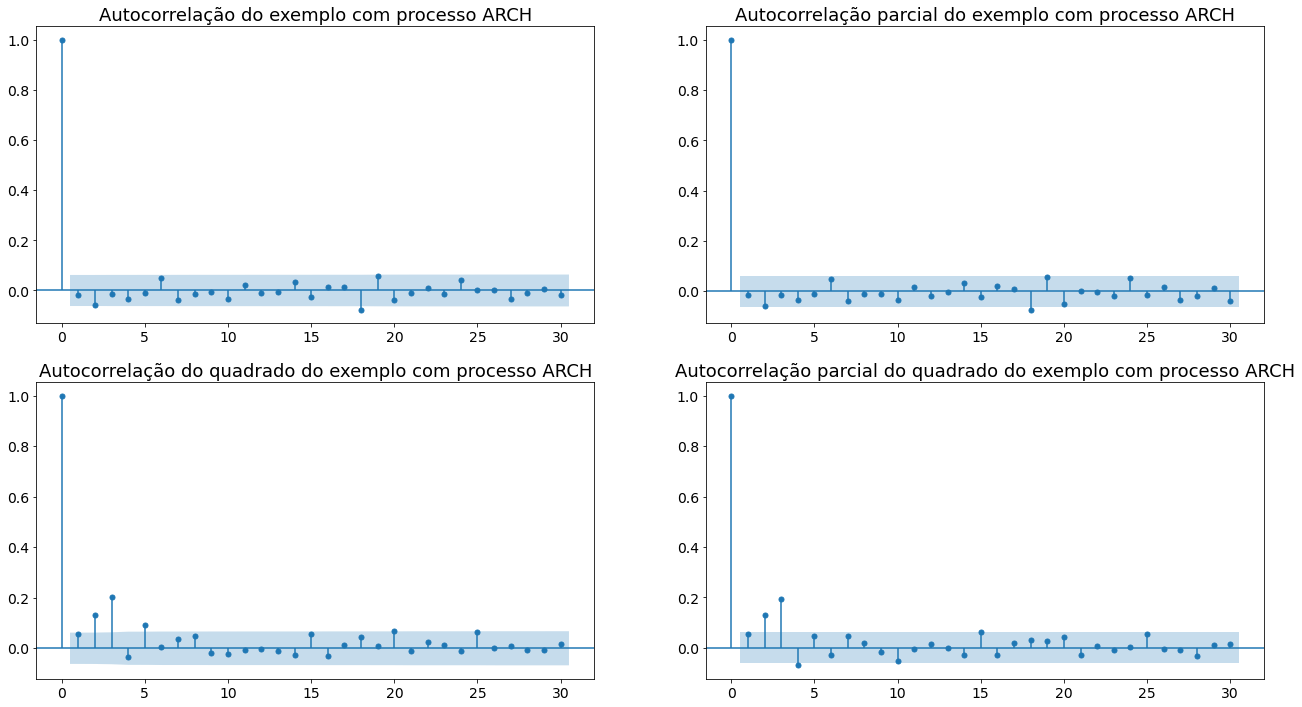

In [29]:
fig, axs = plt.subplots(2,2, figsize=(22,12))
tsa.plot_acf(serie_arch_p, ax = axs[0,0], title="Autocorrelação do exemplo com processo ARCH")
tsa.plot_pacf(serie_arch_p, ax = axs[0,1], title="Autocorrelação parcial do exemplo com processo ARCH")
tsa.plot_acf(serie_arch_p**2, ax = axs[1,0], title="Autocorrelação do quadrado do exemplo com processo ARCH")
_ = tsa.plot_pacf(serie_arch_p**2, ax = axs[1,1], title="Autocorrelação parcial do quadrado do exemplo com processo ARCH")

### Ajustamento

In [30]:
modelo_arch = arch_model(serie_arch_p, vol="ARCH", p=3).fit()
print(modelo_arch.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 3971.490811400796
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2478.2559629569614
Iteration:      3,   Func. Count:     23,   Neg. LLF: 2450.4890356144433
Iteration:      4,   Func. Count:     31,   Neg. LLF: 7398.416891740678
Iteration:      5,   Func. Count:     38,   Neg. LLF: 2407.692511131212
Iteration:      6,   Func. Count:     44,   Neg. LLF: 2408.217361921761
Iteration:      7,   Func. Count:     51,   Neg. LLF: 2407.5964497878927
Iteration:      8,   Func. Count:     57,   Neg. LLF: 2407.5804024203944
Iteration:      9,   Func. Count:     63,   Neg. LLF: 2407.580375164989
Iteration:     10,   Func. Count:     69,   Neg. LLF: 2407.580373587686
Iteration:     11,   Func. Count:     74,   Neg. LLF: 2407.58037358768
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2407.580373587686
            Iterations: 11
            Function evaluations: 74
            Gradient evaluations:

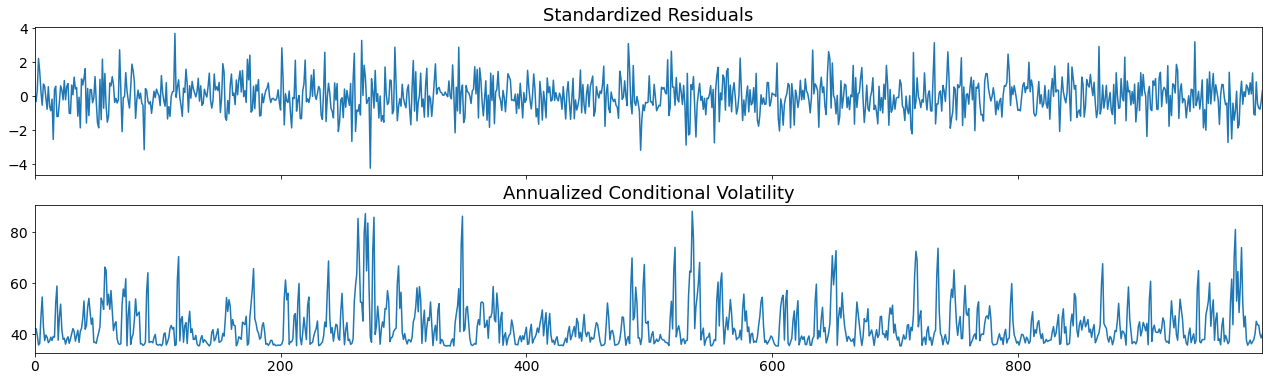

In [31]:
_ = modelo_arch.plot(annualize='D')

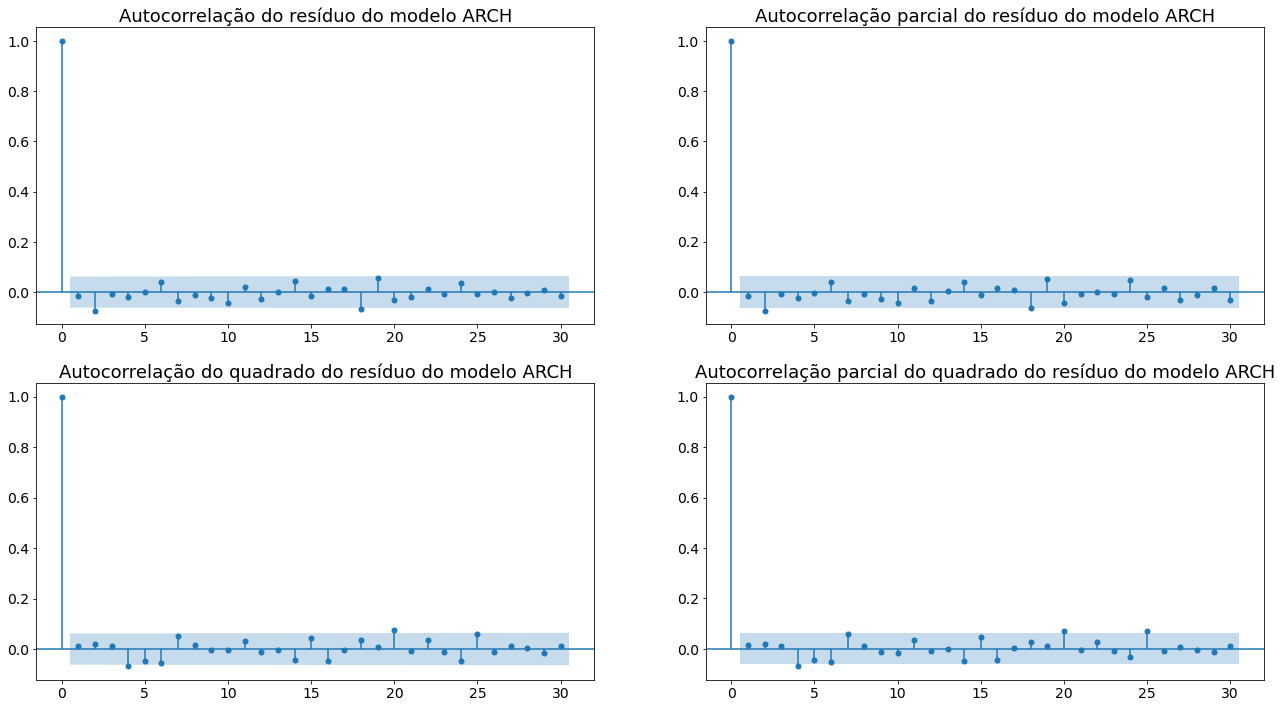

In [32]:
fig, axs = plt.subplots(2,2, figsize=(22,12))
tsa.plot_acf(modelo_arch.std_resid, ax = axs[0,0], title="Autocorrelação do resíduo do modelo ARCH")
tsa.plot_pacf(modelo_arch.std_resid, ax = axs[0,1], title="Autocorrelação parcial do resíduo do modelo ARCH")
tsa.plot_acf(modelo_arch.std_resid**2, ax = axs[1,0], title="Autocorrelação do quadrado do resíduo do modelo ARCH")
_ = tsa.plot_pacf(modelo_arch.std_resid**2, ax = axs[1,1], title="Autocorrelação parcial do quadrado do resíduo do modelo ARCH")

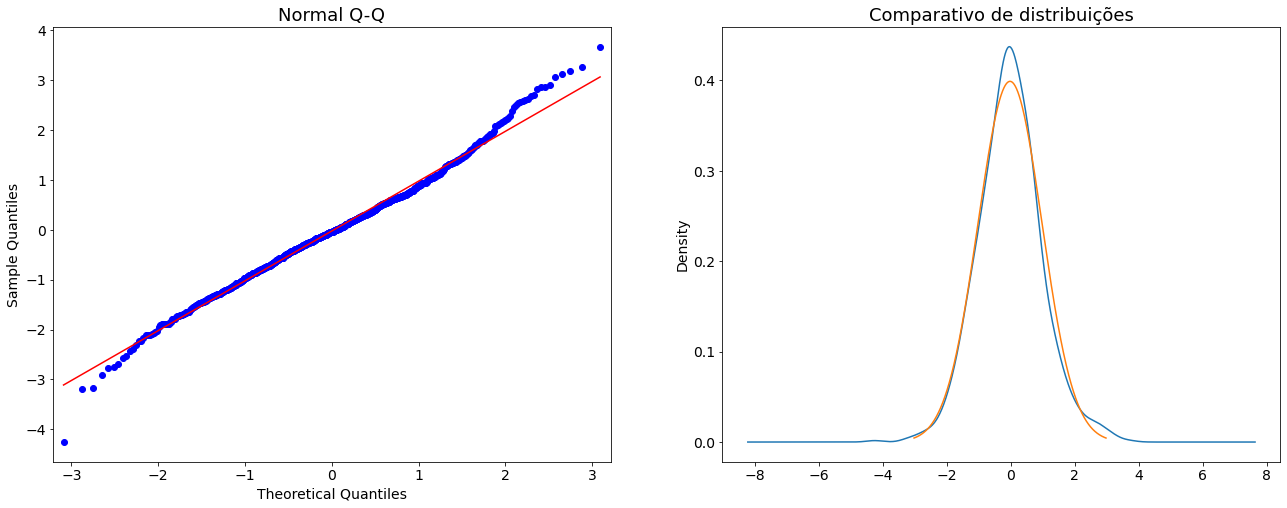

In [35]:
mu = modelo_arch.std_resid.mean()
variance = modelo_arch.std_resid.var()
sigma = np.sqrt(variance)
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 1000)

fig, axs = plt.subplots(1,2, figsize=(22,8))
sm.qqplot(modelo_arch.std_resid, line="s", ax=axs[0])
axs[0].set_title("Normal Q-Q")

modelo_arch.std_resid.plot(kind='kde', ax=axs[1], title= "Comparativo de distribuições")
_ = axs[1].plot(x, stats.norm.pdf(x, mu, sigma), label="oioi")

## GARCH — Generalized Autoregressive Conditional Heteroskedasticity

Assim como ARCH(p) é um modelo autoregressivo AR(p) aplicado na variância da série temporal, GARCH(p,q) é um modelo ARMA(p,q) aplicado na variância da série temporal. O AR(p) modela os resíduos das variâncias ou simplesmente a nossa série quadrática. Já o MA(q) modela a variância do processo.

Um modelo GARCH(1,1) equivale a:

\begin{align}
\sigma^2_t = a*𝜖^2_{t-1} + b*\sigma^2_{t-1} + w
\end{align}

$(a + b)$ precisa ser menor do que 1 para o modelo ser estável.

Sendo assim, GARCH(p,q) possui uma equação equivalente a:

\begin{align}
𝜖_t &= w_t + \sigma_t\\
\sigma^2_t &= \alpha_0 + \sum^q_{i=1}{\alpha_i*𝜖^2_{t-1}} + \sum^p_{j=1}{\beta_j*\sigma^2_{t-1}} + w
\end{align}

Onde:
- p: O número de variâcias atrasados a serem incluídas no modelo.
- q: O número de erros residuais atrasados a serem incluídos no modelo GARCH.

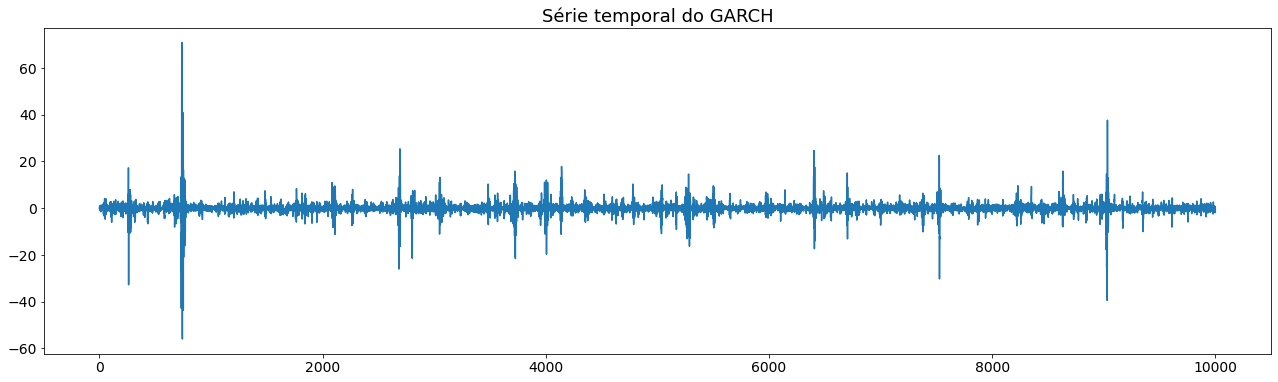

In [58]:
a0 = 0.2
a1 = 0.6
b1 = 0.4

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
  sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
  eps[i] = w[i] * np.sqrt(sigsq[i])

serie_garch = pd.Series(eps)
_ = serie_garch.plot(title="Série temporal do GARCH")

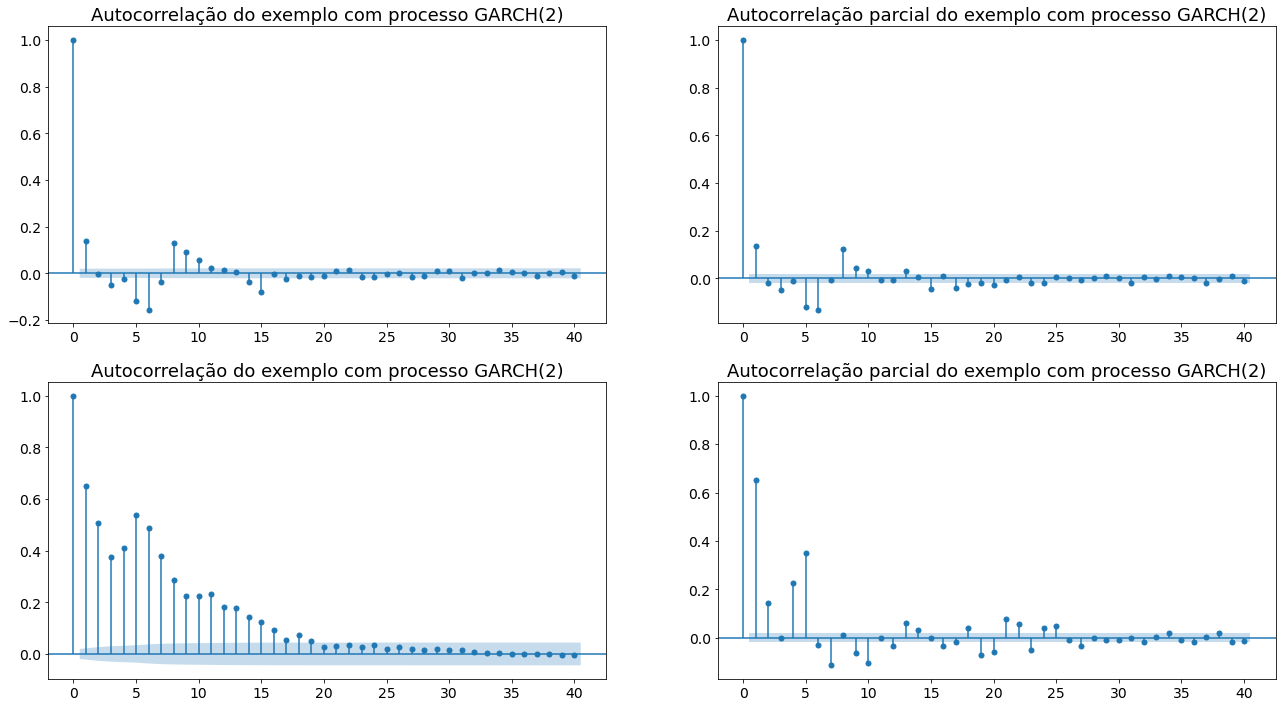

In [61]:
fig, axs = plt.subplots(2,2, figsize=(22,12))
tsa.plot_acf(serie_garch, ax = axs[0,0], title="Autocorrelação do exemplo com processo GARCH(2)")
_ = tsa.plot_pacf(serie_garch, ax = axs[0,1], title="Autocorrelação parcial do exemplo com processo GARCH(2)")
tsa.plot_acf(serie_garch**2, ax = axs[1,0], title="Autocorrelação do exemplo com processo GARCH(2)")
_ = tsa.plot_pacf(serie_garch**2, ax = axs[1,1], title="Autocorrelação parcial do exemplo com processo GARCH(2)")

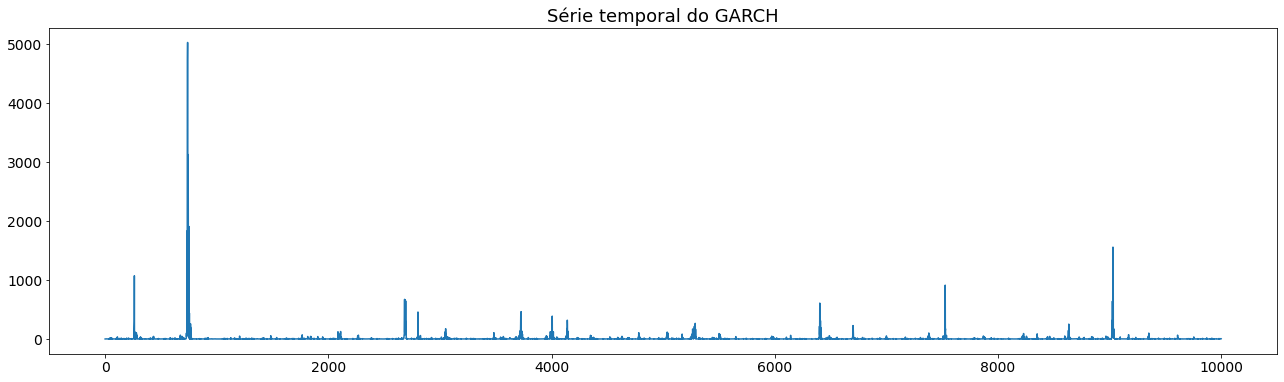

In [62]:
_ = (serie_garch**2).plot(title="Série temporal do GARCH")

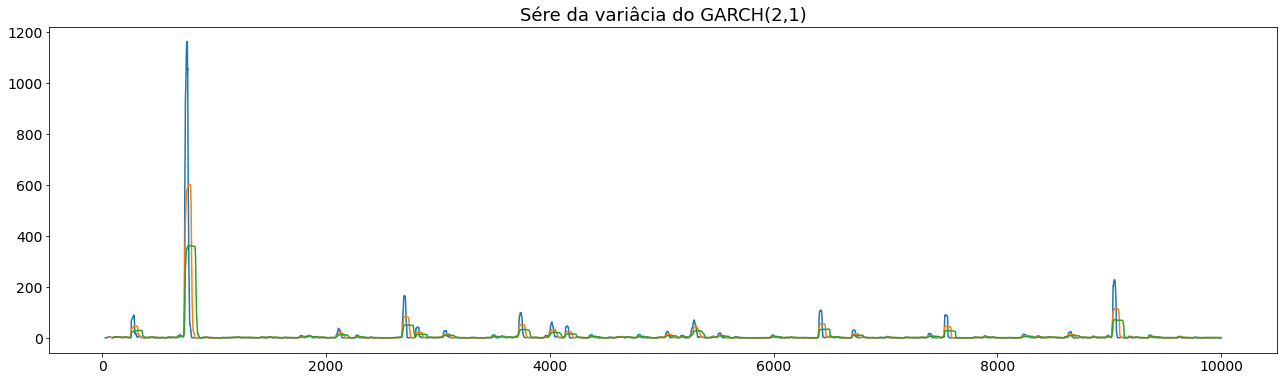

In [63]:
ax = serie_garch.rolling(30).var().plot(title = "Sére da variâcia do GARCH(2,1)")
serie_garch.rolling(60).var().plot(ax = ax, title = "Sére da variâcia do GARCH(2,1)")
_ = serie_garch.rolling(100).var().plot(ax = ax, title = "Sére da variâcia do GARCH(2,1)")

In [64]:
serie_garch_df = serie_garch.to_frame().reset_index()
serie_garch_df.columns = ["time", "value"]

In [65]:
olsr = sm.formula.ols("value ~ time", serie_garch_df).fit()
resultado_white(sm.stats.diagnostic.het_white(olsr.resid, olsr.model.exog))

Statistics=38.436, p-valor=0.00000000

**A série é heterocedástica (rejeitamos H0)**

Há evidências substanciais de um processo heterocedástico condicional por meio do decaimento de defasagens sucessivas. A significância das defasagens tanto no ACF quanto no PACF indicam que precisamos dos componentes AR e MA para nosso modelo. Vamos ver se podemos recuperar nossos parâmetros de processo usando um modelo GARCH(1, 1). Aqui usamos a função arch_model do pacote ARCH.

### Ajustamento

In [66]:
am = arch_model(serie_garch, vol="GARCH", p=1, q=1).fit()
print(am.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 78963282.81153427
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179669721.73118517
Iteration:      3,   Func. Count:     20,   Neg. LLF: 18979.67658054619
Iteration:      4,   Func. Count:     26,   Neg. LLF: 34451.97319695108
Iteration:      5,   Func. Count:     33,   Neg. LLF: 18715.5596042982
Iteration:      6,   Func. Count:     39,   Neg. LLF: 16998.647631384316
Iteration:      7,   Func. Count:     45,   Neg. LLF: 19739.868315339034
Iteration:      8,   Func. Count:     51,   Neg. LLF: 16955.82841862501
Iteration:      9,   Func. Count:     57,   Neg. LLF: 16940.524424072646
Iteration:     10,   Func. Count:     62,   Neg. LLF: 16938.287788547103
Iteration:     11,   Func. Count:     67,   Neg. LLF: 16938.257646455113
Iteration:     12,   Func. Count:     72,   Neg. LLF: 16938.25741389152
Iteration:     13,   Func. Count:     76,   Neg. LLF: 16938.25741304573
Optimization terminated successfully    (Exit mode 0)
     

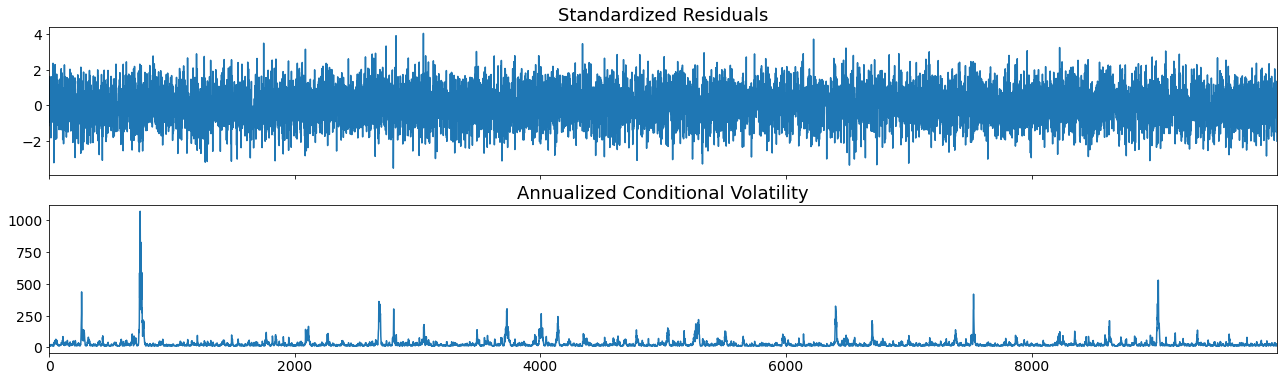

In [67]:
_ = am.plot(annualize='D')

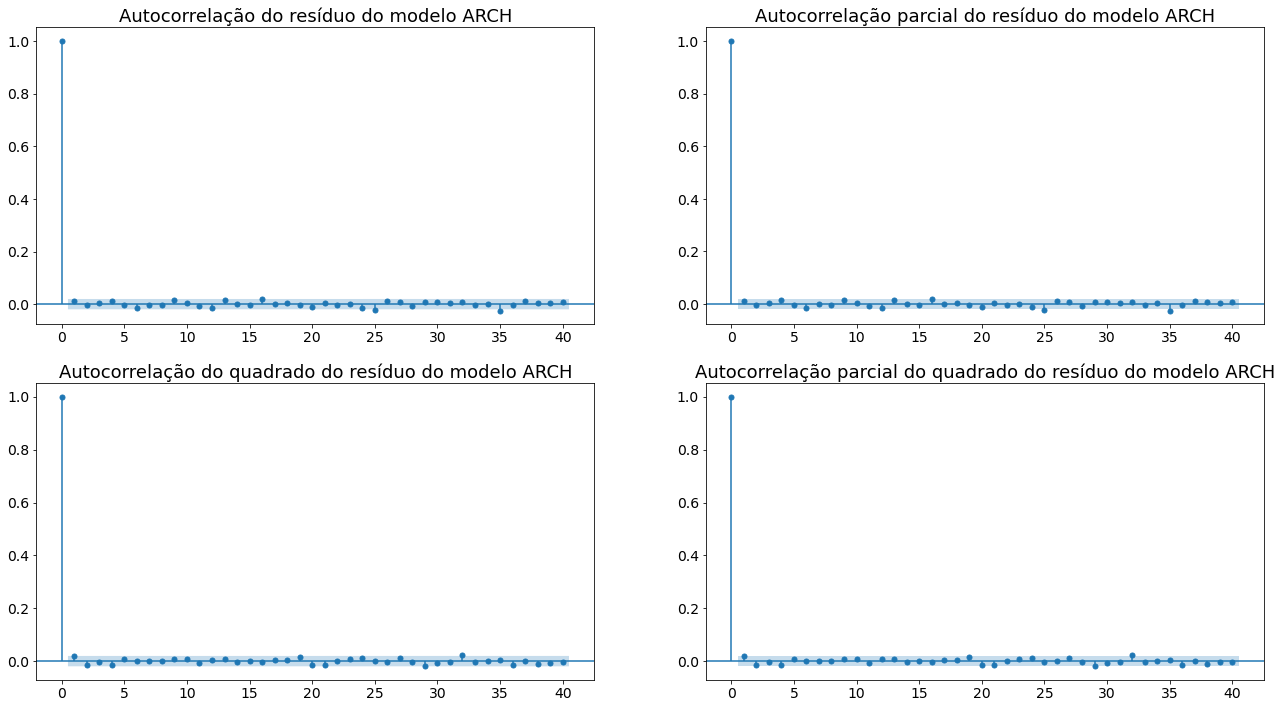

In [68]:
fig, axs = plt.subplots(2,2, figsize=(22,12))
tsa.plot_acf(am.std_resid, ax = axs[0,0], title="Autocorrelação do resíduo do modelo ARCH")
tsa.plot_pacf(am.std_resid, ax = axs[0,1], title="Autocorrelação parcial do resíduo do modelo ARCH")
tsa.plot_acf(am.std_resid**2, ax = axs[1,0], title="Autocorrelação do quadrado do resíduo do modelo ARCH")
_ = tsa.plot_pacf(am.std_resid**2, ax = axs[1,1], title="Autocorrelação parcial do quadrado do resíduo do modelo ARCH")

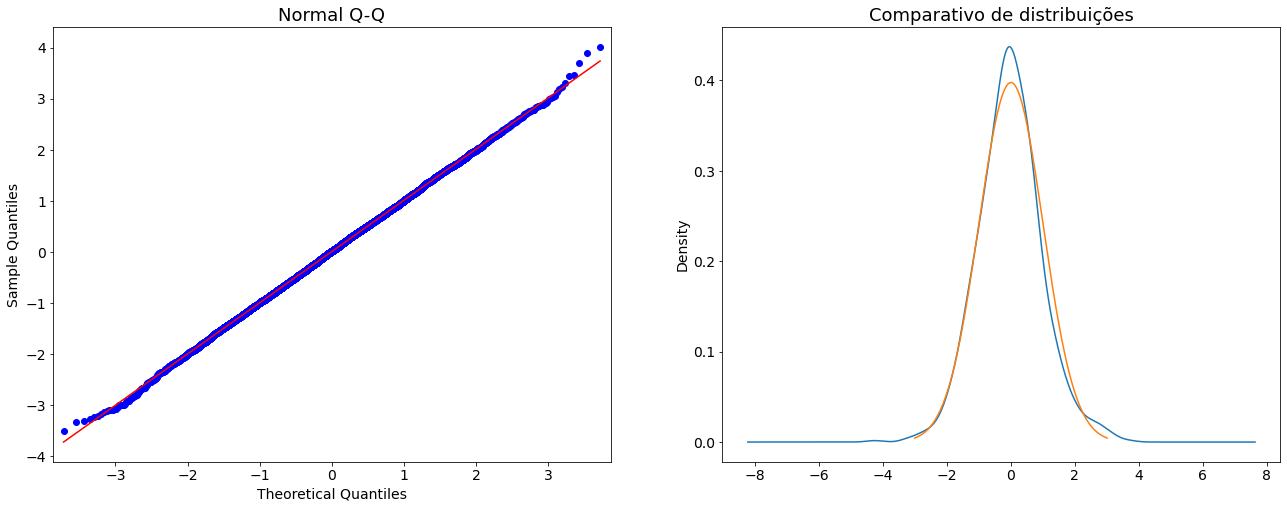

In [69]:
mu = am.std_resid.mean()
variance = am.std_resid.var()
sigma = np.sqrt(variance)
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 1000)

fig, axs = plt.subplots(1,2, figsize=(22,8))
sm.qqplot(am.std_resid, line="s", ax=axs[0])
axs[0].set_title("Normal Q-Q")

modelo_arch.std_resid.plot(kind='kde', ax=axs[1], title= "Comparativo de distribuições")
_ = axs[1].plot(x, stats.norm.pdf(x, mu, sigma))

## Aplicando

#### Analizando a série

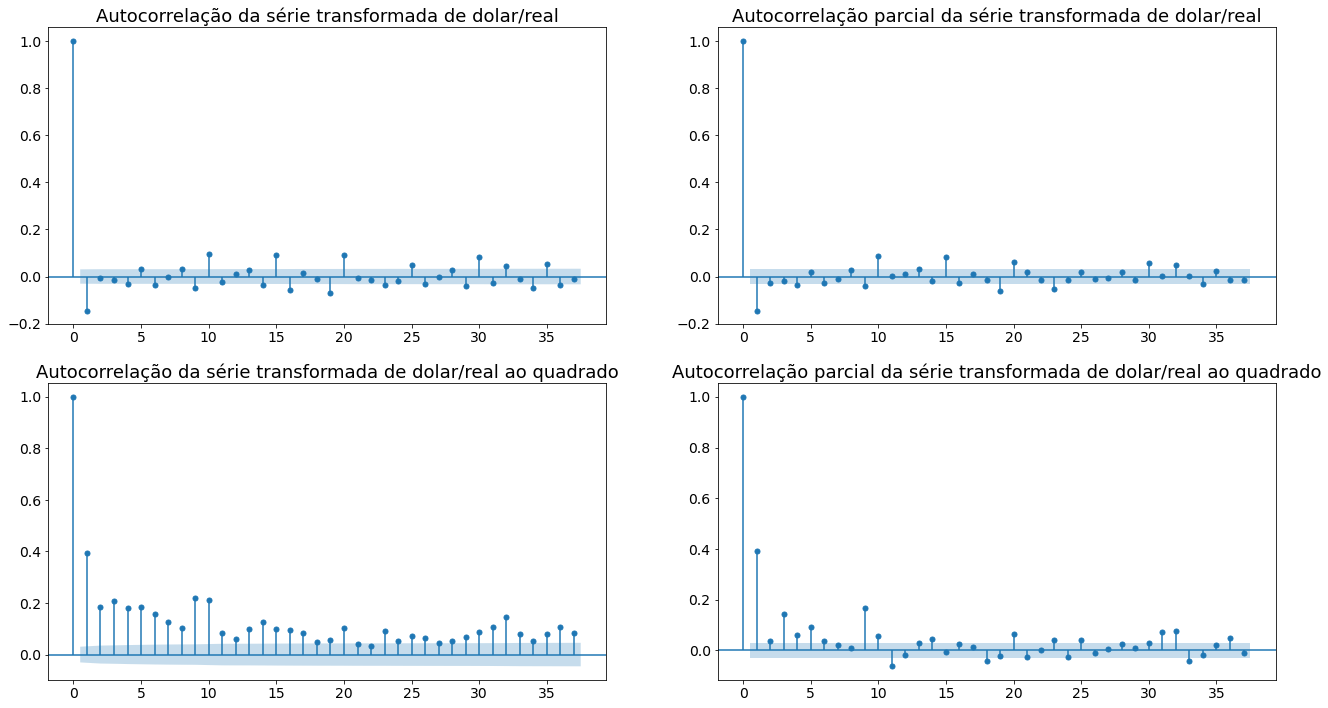

In [70]:
fig, axs = plt.subplots(2,2, figsize=(22,12))
tsa.plot_acf(serie_dolar_df.retornos, ax = axs[0,0], title="Autocorrelação da série transformada de dolar/real")
tsa.plot_pacf(serie_dolar_df.retornos, ax = axs[0,1], title="Autocorrelação parcial da série transformada de dolar/real")
tsa.plot_acf(serie_dolar_df.retornos**2, ax = axs[1,0], title="Autocorrelação da série transformada de dolar/real ao quadrado")
_ = tsa.plot_pacf(serie_dolar_df.retornos**2, ax = axs[1,1], title="Autocorrelação parcial da série transformada de dolar/real ao quadrado")

#### Buscando o melhor modelo

In [71]:
anos = 1
treino = 252 * anos #anos em días úteis

In [72]:
ps = [1,10,15,20]
ds = [0]
qs = [1,10,15,20,30]

parameters = product(ps, ds, qs) # cria uma combinação de todos os parâmetros
parameters_list = list(parameters)

In [73]:
result_df = auto_ARIMA(parameters_list, serie_dolar_df.retornos[-treino:])

  0%|          | 0/20 [00:00<?, ?it/s]

In [74]:
result_df.sort_values(by="MAE", ascending=True).head(10)

,"(p, d, q)",AIC,MAE,MAPE,modelo
19,"(20, 0, 30)",830.545633,0.793960,inf,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
9,"(10, 0, 30)",817.673345,0.802114,inf,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,"(15, 0, 20)",812.663941,0.802449,inf,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,"(15, 0, 30)",824.704850,0.803967,inf,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
14,"(1, 0, 30)",806.645117,0.804311,inf,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
18,"(20, 0, 20)",815.049646,0.808210,inf,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
10,"(10, 0, 20)",806.814400,0.814683,inf,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,"(20, 0, 15)",812.015958,0.819646,inf,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,"(20, 0, 1)",805.165913,0.833472,inf,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
6,"(15, 0, 15)",807.558025,0.833788,inf,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [75]:
melhores_parametros = result_df.sort_values(by="MAE", ascending=True).iloc[2,0]

In [76]:
modelo_dolar_autoarima = sm.tsa.arima.ARIMA(serie_dolar_df.retornos[-treino:], order=melhores_parametros).fit()
print(modelo_dolar_autoarima.summary())

                               SARIMAX Results                                
Dep. Variable:               retornos   No. Observations:                  252
Model:               ARIMA(15, 0, 20)   Log Likelihood                -369.332
Date:                Mon, 27 Feb 2023   AIC                            812.664
Time:                        01:19:41   BIC                            943.253
Sample:                    01-13-2022   HQIC                           865.210
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0071      0.061     -0.116      0.907      -0.126       0.112
ar.L1          0.4316      0.448      0.963      0.335      -0.447       1.310
ar.L2         -0.3217      0.388     -0.828      0.4

#### Analizando os resíduos

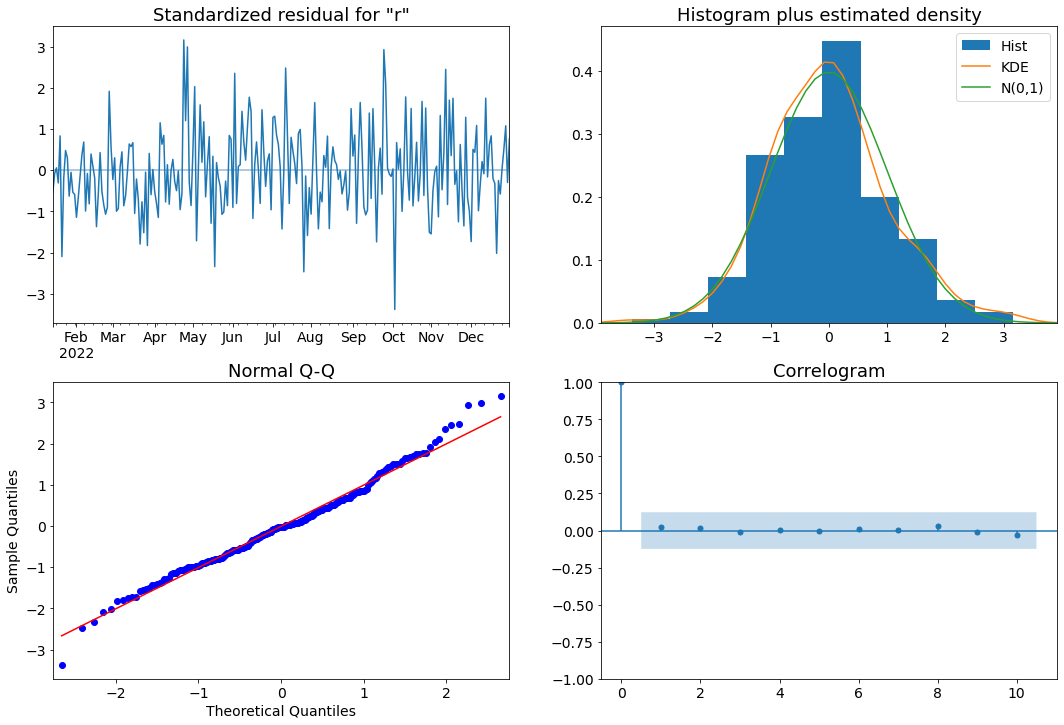

In [77]:
_ = modelo_dolar_autoarima.plot_diagnostics(figsize=(18,12))

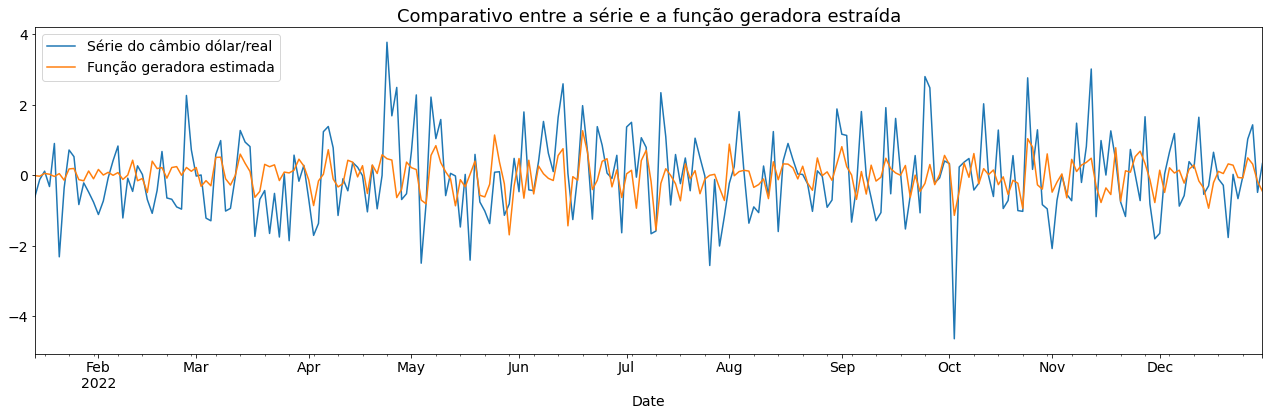

In [78]:
ax = serie_dolar_df.retornos[-treino:].plot(title = "Comparativo entre a série e a função geradora estraída", label="Série do câmbio dólar/real", legend= True)
_ = modelo_dolar_autoarima.fittedvalues.plot(ax = ax, label="Função geradora estimada", legend= True)

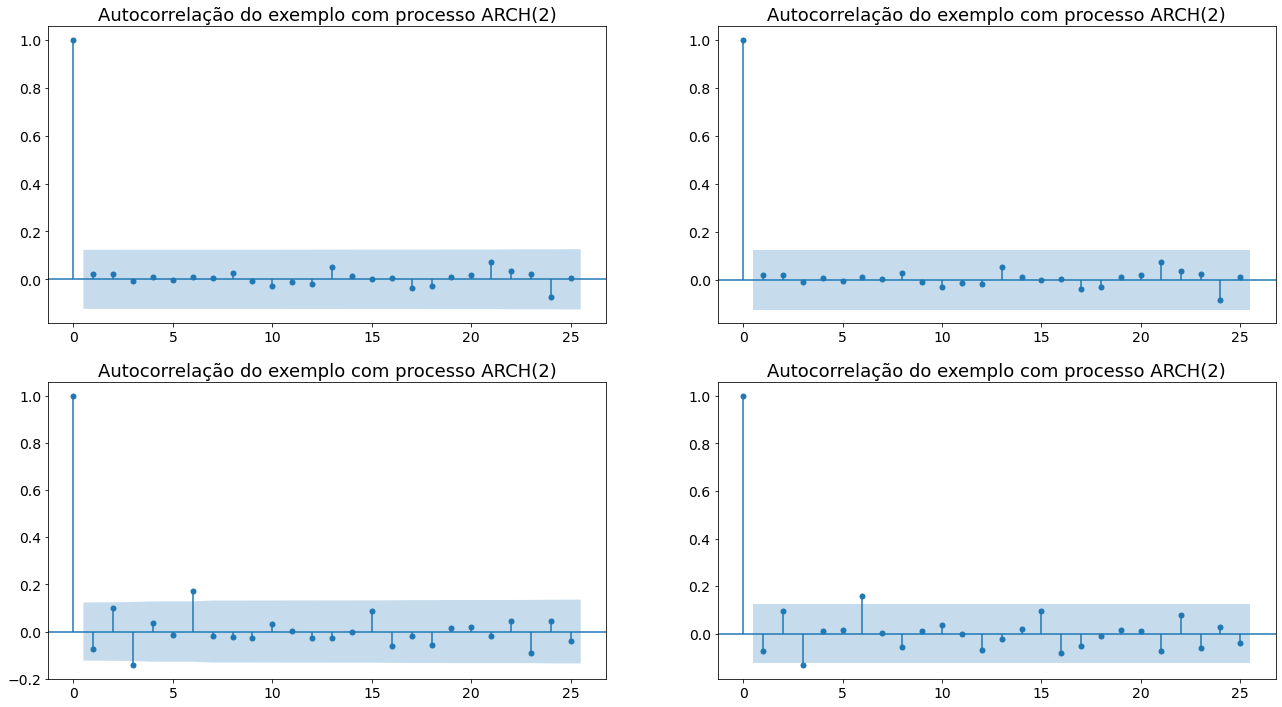

In [79]:
fig, axs = plt.subplots(2,2, figsize=(22,12))
tsa.plot_acf(modelo_dolar_autoarima.resid, ax = axs[0,0], title="Autocorrelação do exemplo com processo ARCH(2)")
tsa.plot_pacf(modelo_dolar_autoarima.resid, ax = axs[0,1], title="Autocorrelação do exemplo com processo ARCH(2)")
tsa.plot_acf(modelo_dolar_autoarima.resid**2, ax = axs[1,0], title="Autocorrelação do exemplo com processo ARCH(2)")
_ = tsa.plot_pacf(modelo_dolar_autoarima.resid**2, ax = axs[1,1], title="Autocorrelação do exemplo com processo ARCH(2)")

In [80]:
residuos_dolar_autoarima = modelo_dolar_autoarima.resid.rename('residuo').to_frame().reset_index(drop=True).reset_index()
residuos_dolar_autoarima.head()

,index,residuo
0,0,-0.605452
1,1,-0.094762
2,2,0.063399
3,3,-0.348772
4,4,0.934922


In [81]:
olsr = sm.formula.ols("residuo ~ index", residuos_dolar_autoarima).fit()
resultado_white(sm.stats.diagnostic.het_white(olsr.resid, olsr.model.exog))

Statistics=3.295, p-valor=0.19251029

**A série não é heterocedástica (falhamos em rejeitar H0)**

#### Treinando o GARCH

In [82]:
ps = [1,8,17]
qs = [1,7,8,17]

parametros_garch = list(product(ps, qs)) # cria uma combinação de todos os parâmetros

In [83]:
result_garch = auto_GARCH(parametros_garch, modelo_dolar_autoarima.resid)

  0%|          | 0/12 [00:00<?, ?it/s]

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1111.1275250928854
Iteration:      2,   Func. Count:     17,   Neg. LLF: 4797.861908893682
Iteration:      3,   Func. Count:     25,   Neg. LLF: 820.7867392684202
Iteration:      4,   Func. Count:     33,   Neg. LLF: 366.8809443007956
Iteration:      5,   Func. Count:     38,   Neg. LLF: 366.83623448864057
Iteration:      6,   Func. Count:     43,   Neg. LLF: 366.83288593401977
Iteration:      7,   Func. Count:     48,   Neg. LLF: 366.82682723321466
Iteration:      8,   Func. Count:     53,   Neg. LLF: 366.823577168972
Iteration:      9,   Func. Count:     58,   Neg. LLF: 366.82351098246494
Iteration:     10,   Func. Count:     63,   Neg. LLF: 366.8235041508034
Iteration:     11,   Func. Count:     67,   Neg. LLF: 366.8235041503284
Optimization terminated successfully    (Exit mode 0)
            Current function value: 366.8235041508034
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations

In [84]:
result_garch.head()

,"(p, q)",AIC
0,"(1, 1)",741.647008
1,"(8, 1)",749.423108
2,"(1, 7)",753.436263
3,"(1, 8)",755.422166
4,"(8, 8)",760.700367


In [85]:
garch_pqs = result_garch.iloc[2,0]
arch_ajustado = arch_model(modelo_dolar_autoarima.resid, vol="GARCH", p=garch_pqs[0], q=garch_pqs[1]).fit()

Iteration:      1,   Func. Count:     12,   Neg. LLF: 970.4913486563132
Iteration:      2,   Func. Count:     27,   Neg. LLF: 2257.7513874628066
Iteration:      3,   Func. Count:     41,   Neg. LLF: 368.35015024172003
Iteration:      4,   Func. Count:     53,   Neg. LLF: 367.1284859781501
Iteration:      5,   Func. Count:     65,   Neg. LLF: 366.8512128703775
Iteration:      6,   Func. Count:     76,   Neg. LLF: 366.83106022626384
Iteration:      7,   Func. Count:     87,   Neg. LLF: 366.8206485890985
Iteration:      8,   Func. Count:     98,   Neg. LLF: 366.9565284507643
Iteration:      9,   Func. Count:    110,   Neg. LLF: 366.8836627342652
Iteration:     10,   Func. Count:    122,   Neg. LLF: 368.4666747149888
Iteration:     11,   Func. Count:    135,   Neg. LLF: 366.76084843971705
Iteration:     12,   Func. Count:    146,   Neg. LLF: 366.7327085292666
Iteration:     13,   Func. Count:    157,   Neg. LLF: 366.7237556676323
Iteration:     14,   Func. Count:    168,   Neg. LLF: 366.72

In [86]:
print(arch_ajustado.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -366.718
Distribution:                  Normal   AIC:                           753.436
Method:            Maximum Likelihood   BIC:                           788.731
                                        No. Observations:                  252
Date:                Mon, Feb 27 2023   Df Residuals:                      251
Time:                        01:22:52   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.0342  6.714e-02     -0.510      0.610 [ -0.166,

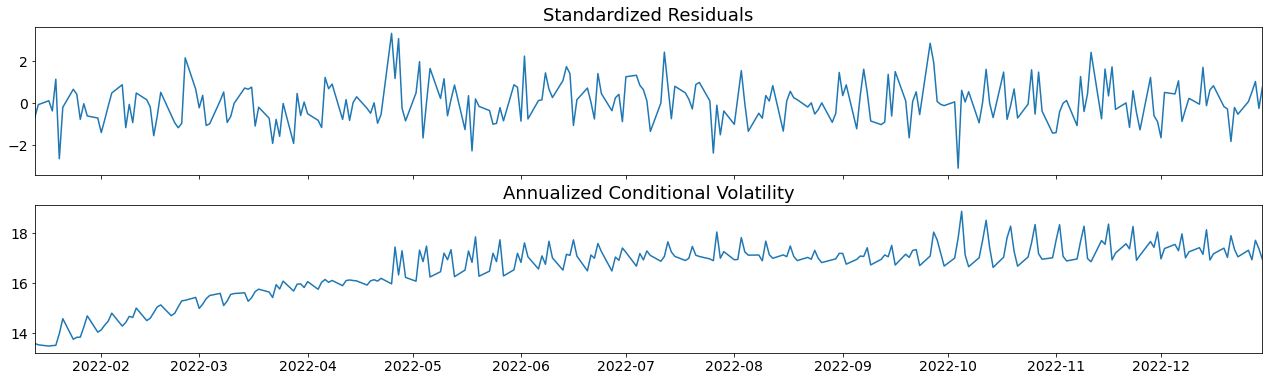

In [87]:
_ = arch_ajustado.plot(annualize='D')

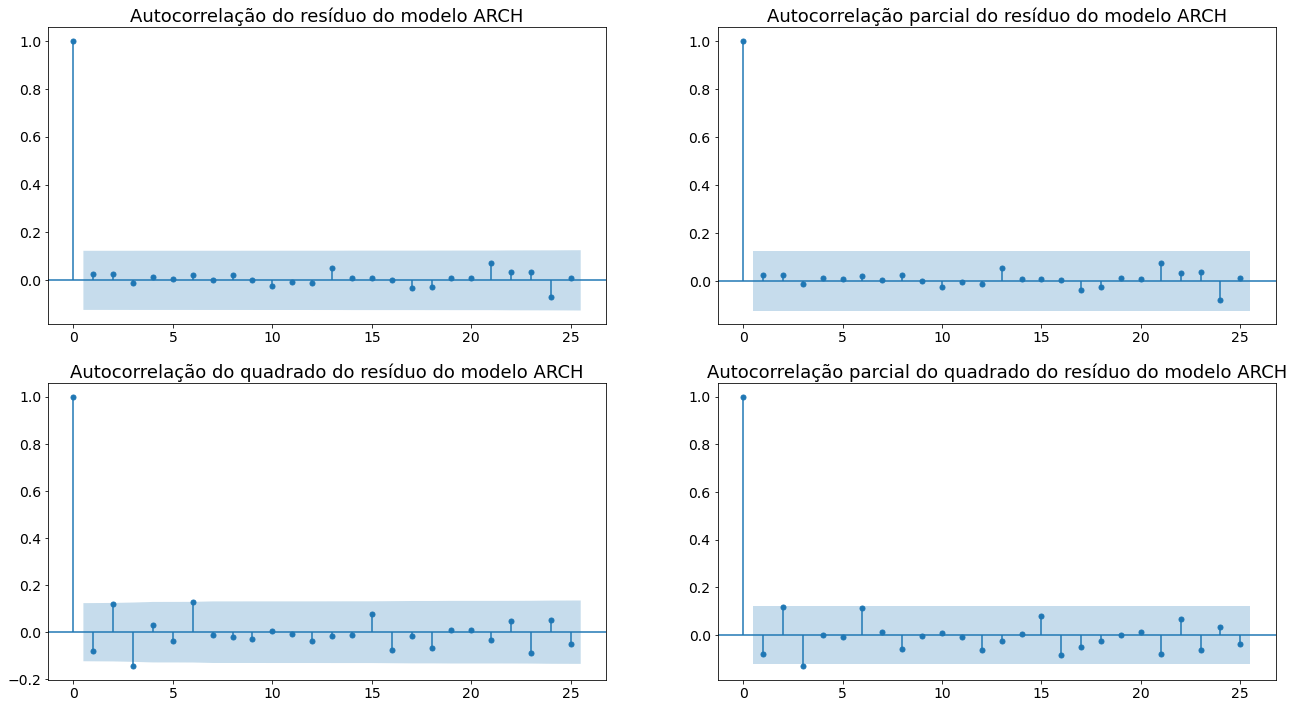

In [89]:
fig, axs = plt.subplots(2,2, figsize=(22,12))
tsa.plot_acf(arch_ajustado.std_resid, ax = axs[0,0], title="Autocorrelação do resíduo do modelo ARCH")
tsa.plot_pacf(arch_ajustado.std_resid, ax = axs[0,1], title="Autocorrelação parcial do resíduo do modelo ARCH")
tsa.plot_acf(arch_ajustado.std_resid**2, ax = axs[1,0], title="Autocorrelação do quadrado do resíduo do modelo ARCH")
_ = tsa.plot_pacf(arch_ajustado.std_resid**2, ax = axs[1,1], title="Autocorrelação parcial do quadrado do resíduo do modelo ARCH")

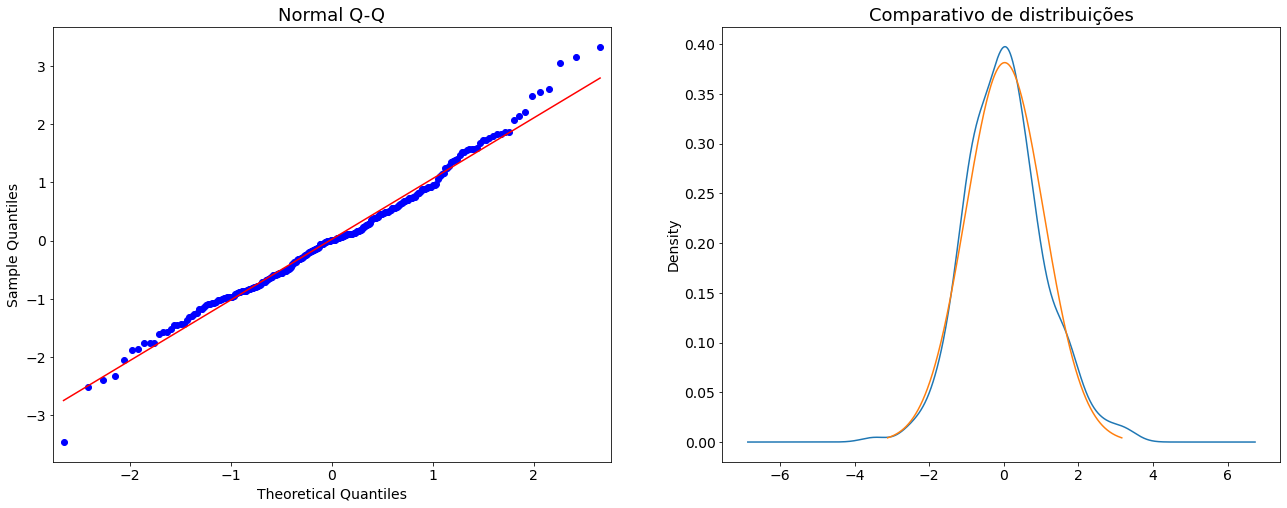

In [90]:
mu = arch_ajustado.resid.mean()
variance = arch_ajustado.resid.var()
sigma = np.sqrt(variance)
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 1000)

fig, axs = plt.subplots(1,2, figsize=(22,8))
sm.qqplot(arch_ajustado.resid, line="s", ax=axs[0])
axs[0].set_title("Normal Q-Q")

arch_ajustado.resid.plot(kind='kde', ax=axs[1], title= "Comparativo de distribuições")
_ = axs[1].plot(x, stats.norm.pdf(x, mu, sigma))

In [91]:
residuos_dolar_garch = arch_ajustado.std_resid.rename('residuo').to_frame().reset_index(drop=True).reset_index()
residuos_dolar_garch.head()

,index,residuo
0,0,-0.667048
1,1,-0.070979
2,2,0.114887
3,3,-0.369681
4,4,1.138067


In [92]:
olsr = sm.formula.ols("residuo ~ index", residuos_dolar_garch).fit()
resultado_white(sm.stats.diagnostic.het_white(olsr.resid, olsr.model.exog))

Statistics=1.283, p-valor=0.52641843

**A série não é heterocedástica (falhamos em rejeitar H0)**

## Exercício

1. Ajuste um modelo ARMA na série de câmbio EURO/REAL e em seguida ajuste um modelo ARCH para tornar o resíduo homocedástico. 
2. Ajuste um modelo ARMA na série de câmbio EURO/REAL e em seguida ajuste um modelo GARCH para tornar o resíduo homocedástico.
3. Ajuste um modelo ARMA na série de temperatura de sua cidade e em seguida ajuste um modelo GARCH para tornaro o resíduo homocedástico.

## Referências
- Livro "Análise de Séries Temporais" - Clélia Tolon & Pedro Morettin
- https://towardsdatascience.com/how-to-detect-heteroskedasticity-in-time-series-3413a8aa8da9
- https://www.quantstart.com/articles/Generalised-Autoregressive-Conditional-Heteroskedasticity-GARCH-p-q-Models-for-Time-Series-Analysis/
- https://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#GARCH=
- https://www.quantstart.com/articles/Generalised-Autoregressive-Conditional-Heteroskedasticity-GARCH-p-q-Models-for-Time-Series-Analysis/
- https://medium.com/analytics-vidhya/a-step-by-step-implementation-of-a-trading-strategy-in-python-using-arima-garch-models-b622e5b3aa39